# PySpark for generating Levy Walks using KASI Clouds

> Using `scipy` and `pyspark`, we need to generate *Levy Walks* which partially mimic a cosmic halo distribution obtained from the HR4 simulation.

## Install basic packages for KASI Kubernetes Cluster

In [2]:
!pip3 install -U pip setuptools wheel

    100% |████████████████████████████████| 1.6MB 924kB/s eta 0:00:01
    100% |████████████████████████████████| 788kB 1.7MB/s eta 0:00:01
  Found existing installation: pip 9.0.1
    Not uninstalling pip at /usr/lib/python3/dist-packages, outside environment /usr
  Found existing installation: setuptools 39.0.1
    Not uninstalling setuptools at /usr/lib/python3/dist-packages, outside environment /usr
  Found existing installation: wheel 0.30.0
    Not uninstalling wheel at /usr/lib/python3/dist-packages, outside environment /usr


In [3]:
!pip3 install -U numpy scipy pandas koalas pyarrow scikit-learn matplotlib astropy astroML

     |████████████████████████████████| 14.8 MB 6.4 MB/s eta 0:00:01     |██████████████████████████▏     | 12.1 MB 7.6 MB/s eta 0:00:01     |███████████████████████████▉    | 12.9 MB 7.6 MB/s eta 0:00:01
  Using cached scipy-1.5.4-cp36-cp36m-manylinux1_x86_64.whl (25.9 MB)
     |████████████████████████████████| 9.5 MB 6.2 MB/s eta 0:00:011     |████████████████████████████▍   | 8.4 MB 6.2 MB/s eta 0:00:01
     |████████████████████████████████| 720 kB 10.6 MB/s eta 0:00:01
     |████████████████████████████████| 21.9 MB 7.4 MB/s eta 0:00:01     |███████████████                 | 10.3 MB 6.9 MB/s eta 0:00:02     |█████████████████               | 11.6 MB 6.9 MB/s eta 0:00:02
     |████████████████████████████████| 22.2 MB 177 kB/s  eta 0:00:01   |████▋                           | 3.2 MB 8.5 MB/s eta 0:00:03
     |████████████████████████████████| 11.5 MB 8.7 MB/s eta 0:00:01
     |████████████████████████████████| 10.3 MB 8.9 MB/s eta 0:00:01
     |████████████████████████████████| 10

## Import Basic Libraries

In [4]:
# generate edges 
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import gc

# plot settings
plt.rc('font', family='serif') 
plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'

In [5]:
import pyarrow.parquet as pq

In [6]:
# Basic PySpark Libraries


from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

spark = SparkSession \
        .builder \
        .appName('pyspark-app') \
        .getOrCreate()

sc = spark.sparkContext
sqlsc = SQLContext(sc)
#sc.setCheckpointDir("hdfs://master:54310/tmp/spark/checkpoints")
#sc.setCheckpointDir("./checkpoints") # local file system yet; no hdfs

import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark import Row
from pyspark.sql.window import Window as W

#spark.conf.set("ARROW_PRE_0_15_IPC_FORMAT","1") #pyarrow 0.15.x need this option
#spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [7]:
#sc.getConf().getAll()

In [8]:
# Enable Arrow for boosting up python performances 
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
spark.conf.set('spark.debug.maxToStringFields',50)

In [9]:
sc.getConf().getAll()

[('spark.app.startTime', '1620630880757'),
 ('spark.executor.id', 'driver'),
 ('spark.app.name', 'PySparkShell'),
 ('spark.app.id', 'app-20210510071442-0000'),
 ('spark.driver.host', 'spark-test-extra-master'),
 ('spark.sql.catalogImplementation', 'hive'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.sql.warehouse.dir', 'file:/mnt/spark/spark-warehouse'),
 ('spark.submit.pyFiles', ''),
 ('spark.master', 'spark://spark-test-extra-master:7077'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.port', '42499'),
 ('spark.ui.showConsoleProgress', 'true')]

## Tutorial Getting Pi

In [10]:
from random import random
from operator import add

In [11]:
partitions = 4
n = 10000 * partitions

In [12]:
def f(_):
    x = np.random.rand() * 2.0 - 1.0
    y = np.random.rand() * 2.0 - 1.0
    return 1 if x ** 2 + y ** 2 <= 1.0 else 0

In [13]:
%%time
count = sc.parallelize(range(1, n + 1), partitions).map(f).reduce(add)
print("Pi is roughly %.20f" % (4.0 * count / n))

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 3 in stage 0.0 failed 4 times, most recent failure: Lost task 3.3 in stage 0.0 (TID 15) (10.0.1.72 executor 0): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/spark-3.1.1-bin-hadoop3.2/python/lib/pyspark.zip/pyspark/worker.py", line 586, in main
    func, profiler, deserializer, serializer = read_command(pickleSer, infile)
  File "/opt/spark-3.1.1-bin-hadoop3.2/python/lib/pyspark.zip/pyspark/worker.py", line 69, in read_command
    command = serializer._read_with_length(file)
  File "/opt/spark-3.1.1-bin-hadoop3.2/python/lib/pyspark.zip/pyspark/serializers.py", line 160, in _read_with_length
    return self.loads(obj)
  File "/opt/spark-3.1.1-bin-hadoop3.2/python/lib/pyspark.zip/pyspark/serializers.py", line 430, in loads
    return pickle.loads(obj, encoding=encoding)
  File "/opt/spark-3.1.1-bin-hadoop3.2/python/lib/pyspark.zip/pyspark/cloudpickle/cloudpickle.py", line 562, in subimport
    __import__(name)
ModuleNotFoundError: No module named 'numpy'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:517)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:652)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:635)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:470)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:315)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:313)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:307)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:307)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:294)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:288)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1030)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2242)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2202)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2201)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1078)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2440)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2382)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2371)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2202)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2223)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2242)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2267)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:180)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/spark-3.1.1-bin-hadoop3.2/python/lib/pyspark.zip/pyspark/worker.py", line 586, in main
    func, profiler, deserializer, serializer = read_command(pickleSer, infile)
  File "/opt/spark-3.1.1-bin-hadoop3.2/python/lib/pyspark.zip/pyspark/worker.py", line 69, in read_command
    command = serializer._read_with_length(file)
  File "/opt/spark-3.1.1-bin-hadoop3.2/python/lib/pyspark.zip/pyspark/serializers.py", line 160, in _read_with_length
    return self.loads(obj)
  File "/opt/spark-3.1.1-bin-hadoop3.2/python/lib/pyspark.zip/pyspark/serializers.py", line 430, in loads
    return pickle.loads(obj, encoding=encoding)
  File "/opt/spark-3.1.1-bin-hadoop3.2/python/lib/pyspark.zip/pyspark/cloudpickle/cloudpickle.py", line 562, in subimport
    __import__(name)
ModuleNotFoundError: No module named 'numpy'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:517)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:652)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:635)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:470)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:315)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:313)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:307)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:307)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:294)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:288)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1030)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2242)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


## Reading data from the KASI Object Storage

In [15]:
'''
sc._jsc.hadoopConfiguration().set("fs.s3a.access.key", "shongscience")
sc._jsc.hadoopConfiguration().set("fs.s3a.secret.key", "shongscience!@#")
sc._jsc.hadoopConfiguration().set("fs.s3a.proxy.host", "minio-service")
sc._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "minio")
sc._jsc.hadoopConfiguration().set("fs.s3a.proxy.port", "9000")
sc._jsc.hadoopConfiguration().set("fs.s3a.path.style.access", "true")
sc._jsc.hadoopConfiguration().set("fs.s3a.connection.ssl.enabled", "false")
sc._jsc.hadoopConfiguration().set("fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
'''

'\nsc._jsc.hadoopConfiguration().set("fs.s3a.access.key", "shongscience")\nsc._jsc.hadoopConfiguration().set("fs.s3a.secret.key", "shongscience!@#")\nsc._jsc.hadoopConfiguration().set("fs.s3a.proxy.host", "minio-service")\nsc._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "minio")\nsc._jsc.hadoopConfiguration().set("fs.s3a.proxy.port", "9000")\nsc._jsc.hadoopConfiguration().set("fs.s3a.path.style.access", "true")\nsc._jsc.hadoopConfiguration().set("fs.s3a.connection.ssl.enabled", "false")\nsc._jsc.hadoopConfiguration().set("fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")\n'

In [10]:
#sc.setCheckpointDir("s3a://tmp/checkpoints")

In [11]:
# for accessing to S3 of AWS
#sc._jsc.hadoopConfiguration().set("fs.s3a.access.key","your-access-key")
#sc._jsc.hadoopConfiguration().set("fs.s3a.secret.key","your-secret-key")

In [17]:
'''
df = spark.read \
    .format('csv') \
    .option('header','true') \
    .load('s3a://shongdata/BreadBasket_DMS.csv', schema=bakery_schema)
'''

"\ndf = spark.read     .format('csv')     .option('header','true')     .load('s3a://shongdata/BreadBasket_DMS.csv', schema=bakery_schema)\n"

## Reading data from the KASI NFS

In [16]:
sc.setCheckpointDir("/mnt/spark/checkpoints")

In [19]:
bakery_schema = T.StructType([
    T.StructField('date', T.StringType(), True),
    T.StructField('time', T.StringType(), True),
    T.StructField('transaction', T.IntegerType(), True),
    T.StructField('item', T.StringType(), True)
])

In [20]:
df = spark.read \
    .format('csv') \
    .option('header','true') \
    .load('/mnt/spark/BreadBasket_DMS.csv', schema=bakery_schema)

In [21]:
df.show(10)

+----------+--------+-----------+-------------+
|      date|    time|transaction|         item|
+----------+--------+-----------+-------------+
|2016-10-30|09:58:11|          1|        Bread|
|2016-10-30|10:05:34|          2| Scandinavian|
|2016-10-30|10:05:34|          2| Scandinavian|
|2016-10-30|10:07:57|          3|Hot chocolate|
|2016-10-30|10:07:57|          3|          Jam|
|2016-10-30|10:07:57|          3|      Cookies|
|2016-10-30|10:08:41|          4|       Muffin|
|2016-10-30|10:13:03|          5|       Coffee|
|2016-10-30|10:13:03|          5|       Pastry|
|2016-10-30|10:13:03|          5|        Bread|
+----------+--------+-----------+-------------+
only showing top 10 rows



In [23]:
%%time
df.describe().show()

+-------+----------+--------+------------------+----------------+
|summary|      date|    time|       transaction|            item|
+-------+----------+--------+------------------+----------------+
|  count|     21293|   21293|             21293|           21293|
|   mean|      null|    null| 4951.990889024562|            null|
| stddev|      null|    null|2787.7583996983885|            null|
|    min|2016-10-30|01:21:05|                 1|      Adjustment|
|    max|2017-04-09|23:38:41|              9684|Victorian Sponge|
+-------+----------+--------+------------------+----------------+

CPU times: user 3.87 ms, sys: 0 ns, total: 3.87 ms
Wall time: 637 ms


## Testing Levy Walks

In [24]:
from scipy.stats import uniform

In [25]:
def levy_periodic(rzero,inpow,x,y,z,sysL=1.0):
    # 3-D Levy Walks
    tmppi = uniform.rvs(loc=0.0,scale=2.*np.pi)
    tmpcos = 2.0*uniform.rvs() - 1.0
    tmpsin = np.sqrt(1.0 - tmpcos*tmpcos)  
    tmpl = rzero * np.power(uniform.rvs(), -1.0/inpow)
    
    nx = x + tmpl * tmpsin * np.cos(tmppi)
    ny = y + tmpl * tmpsin * np.sin(tmppi)
    nz = z + tmpl * tmpcos
    
    #print(x,y,z,nx,ny,nz)
    
    # Periodic Boundary
    if nx >= sysL:
        nx = nx - sysL * np.floor(nx/sysL)
    if ny >= sysL:
        ny = ny - sysL * np.floor(ny/sysL)
    if nz >= sysL:
        nz = nz - sysL * np.floor(nz/sysL)
    
    if nx < 0.0:
        nx = nx + sysL * (1.0 + np.floor(np.abs(nx)/sysL))
    if ny < 0.0:
        ny = ny + sysL * (1.0 + np.floor(np.abs(ny)/sysL))
    if nz < 0.0:
        nz = nz + sysL * (1.0 + np.floor(np.abs(nz)/sysL))
        
    return np.double([nx,ny,nz,tmpl])

In [26]:
# test the first Levy Walk
levy_periodic(1.0,1.2,0.0,0.0,0.0,sysL=100)

array([ 0.13701489,  1.01036137, 99.48153774,  1.14385588])

In [27]:
levy_periodic(1.0,1.2,0.5,0.5,0.5,sysL=1.0)

array([0.58282981, 0.37895871, 0.10120264, 4.29550599])

In [28]:
xlv = []
ylv = []
zlv = []
llv = []
numlv = 2000

walker = np.double([0.5,0.5,0.5,0.5])

#xlv.append(walker[0])
#ylv.append(walker[1])
#zlv.append(walker[2])
#llv.append(walker[3])
for i in range(numlv):
    walker = levy_periodic(0.01,1.2,walker[0],walker[1],walker[2],sysL=1.0)
    xlv.append(walker[0])
    ylv.append(walker[1])
    zlv.append(walker[2])
    llv.append(walker[3])

## Measuring Two-point Functions

In [29]:
from astroML.correlation import two_point

In [30]:
Xlv = np.stack([xlv,ylv,zlv],axis=1)

In [31]:
bins, binstep = np.linspace(np.log10(0.005), np.log10(1.0), 25, retstep=True)

In [32]:
xbins = bins[1:] - binstep*0.5
xbins = np.power(10,xbins)

In [33]:
bins = np.power(10,bins)

In [34]:
corr = two_point(Xlv, bins)

In [35]:
corr.shape

(24,)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


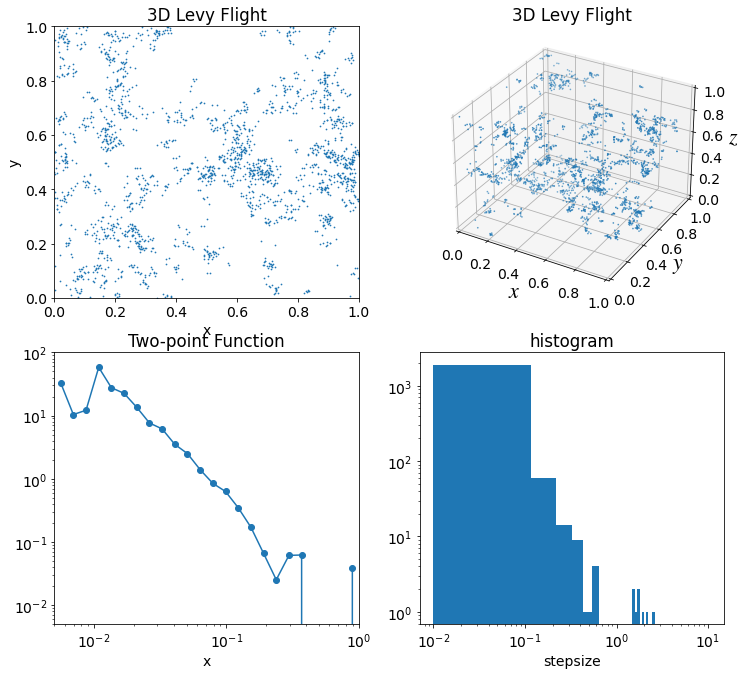

In [36]:
from mpl_toolkits.mplot3d import Axes3D


# plot settings
plt.rc('font', family='serif') 
plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 14})
plt.rcParams['mathtext.fontset'] = 'stix'

# initialize figure
fig = plt.figure( figsize=(12,11) )

# plot 2D random walk with Levy stepsize
plt.subplot(221)
plt.axis([0,1,0,1])
plt.scatter( xlv, ylv, s=0.5 )
plt.xlabel( 'x' )
plt.ylabel( 'y' )
plt.title(r'3D Levy Flight' )

ax = fig.add_subplot(222, projection='3d')
ax.set_title(r'3D Levy Flight')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)

ax.scatter(xlv,ylv,zlv,s=0.5)
ax.set_xlabel(r'$x$',fontsize=22)
ax.set_ylabel(r'$y$',fontsize=22)
ax.set_zlabel(r'$z$',fontsize=22)

# plot histogram
plt.subplot(223)

plt.axis([0.005,1,0.005,100])
plt.yscale( 'log' )
plt.xscale( 'log' )
plt.xlabel( 'x' )
plt.title( 'Two-point Function' )
plt.scatter(xbins,corr)
plt.plot(xbins,corr)

# plot histogram
plt.subplot(224)
#num_bins = n/10
plt.hist( llv, bins=100 )
plt.yscale( 'log' )
plt.xscale( 'log' )
plt.xlabel( 'stepsize' )
plt.title( 'histogram' )

plt.show()

> 20000 training sample and 7000 testing sample 

In [37]:
pwd

'/mnt/spark'